
Hi Oliver,

Entschuldige die Verspätung. Ich hatte leider viel zu tun, und war auch etwas eigensinnig. Da wir für das nächste Projekt ebenfalls I-V sowie ladungsaufgelösten Kurven für SS junctions benötigen, habe ich gedacht, dass ich einfach einen Code schreibe, der für beides funktioniert.

In dem folgenden Dropbox link kannst du die Daten sehen:
https://cloud.uni-konstanz.de/index.php/f/136669082

Diese sind wie folgt strukturiert:

P1_results_new_<Transmission>_n_20_T_<k_B*Temperatur in units of Delta>_NE_5000_Nchi_50.mat

Die Sachen wie n = 20, N_E = 5000 und N_chi = 50 sind nicht relevant für dich.

In jedem der Dateien gibt es die folgenden Grössen:

eV_eff_range = Die Spannung als Funktion von der Energielücke Delta

I_In = Der Strom in units of eDelta/h. 

S_In = Shotnoise (nicht relevant für dich)

In_final = Ladungsaugelöste Ströme von n = -20 bis n= 20. Also Quasiteiclhen sind bei n = 22. 

Falls du irgendwelche Fragen hast, frage bitte. :)

Beste Grüsse,
David


In [1]:
# Retrieve Data
import os, pickle
import numpy as np
from scipy.io import loadmat

path='MARS'
files = os.listdir(path)

arr = loadmat(f'{path}/{files[10]}')

V = np.array(arr['eV_eff_range'][0], dtype='float64')
I_0= np.full((len(files)+1, len(V)), 0, dtype='float64')
I_m = np.full((len(files)+1, 20, len(V)), 0, dtype='float64')
tau = np.full(len(files)+1, 0, dtype='float64')
M = np.arange(1,21)

arr = loadmat(f'{path}/{files[80]}')

for i, file in enumerate(files):
    arr = loadmat(f'{path}/{file}')
    I_0[i+1,:] = np.real(arr['I_In'][:,0])/2
    tau[i+1] = float(file[15:19])
    for j,m in enumerate(M):
        I_m[i+1,j,:] = np.real(arr['In_final'][:,20-m]/2+arr['In_final'][:,20+m]/2)

sorting_indices = np.argsort(tau)
tau = tau[sorting_indices]
I_0 = I_0[sorting_indices, :]
I_m = I_m[sorting_indices, :, :]


V = np.concatenate(
    (
    V[:590], 
    -np.linspace(.09, .01, 9), 
    np.linspace(0, .09, 10), 
    V[590:]
    ),
    )

I_0 = np.concatenate(
    (
    I_0[:,:590],
    np.full((len(files)+1, 19), np.nan),
    I_0[:,590:]
    ),
    axis=1,
    )

I_m = np.concatenate(
    (
    I_m[:,:,:590],
    np.full((len(files)+1, 20, 19), np.nan),
    I_m[:,:,590:]
    ),
    axis=2,
    )

dIdV = np.gradient(I_0, V, axis=1)
dIdV_m = np.gradient(I_m, V, axis=2)

mars = {
    'V': V,
    'tau': tau,
    'I': I_0,
    'dIdV': dIdV,
    'm': m,
    'I_m': I_m,
    'dIdV_m': dIdV_m,
}

with open('DavidOIV.pickle', 'wb') as f:
    pickle.dump(mars, f)

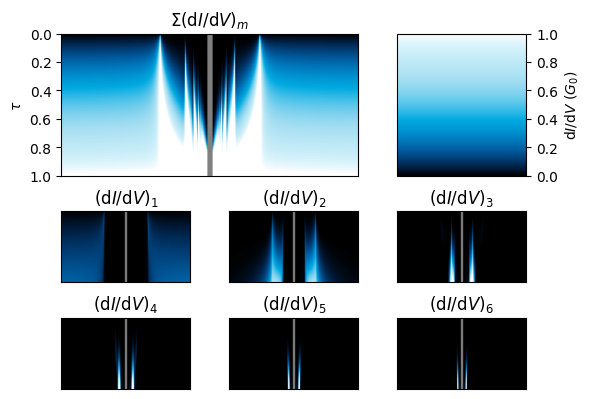

In [2]:
# show I_m over tau, V
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
sys.path.append("/Users/oliver/Documents/p5control-bluefors-evaluation")
from utilities.corporate_design_colors_v4 import cmap

fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[4, 2, 2, 2], hspace=0.4, wspace=0.3)
ax_main = fig.add_subplot(gs[0, 0:2])
cax = fig.add_subplot(gs[0, 2])

Z = dIdV
im = ax_main.imshow(Z, 
           aspect='auto', 
           origin='upper', 
           extent=(min(V), max(V), max(tau), min(tau)),
           clim=(0,1),
           cmap=cmap(bad='grey'),
           )
fig.colorbar(im, cax=cax, label=r'd$I/$d$V$ ($G_0$)')
# ax_main.set_xlabel(r'$eV_0$ ($\Delta$)')
ax_main.set_xticks([])
ax_main.set_ylabel(r'$\tau$')
ax_main.set_title(r'$\Sigma($d$I/$d$V)_m$')

axes_small = [
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[1, 2]),
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[2, 2]),
]
Z_m = dIdV_m
for i in range(6):
    axes_small[i].imshow(
        Z_m[:,i,:],
           aspect='auto', 
           origin='upper', 
           extent=(min(V), max(V), max(tau), min(tau)),
           clim=(0,5),
           cmap=cmap(bad='grey'),
        )
    axes_small[i].set_title(f'$($d$I/$d$V)_{i+1}$')
    axes_small[i].set_xticks([])
    axes_small[i].set_yticks([])

In [3]:
tau_i = .5
M = 10


In [ ]:
# Show I_0(tau) and I_m(tau) over V
%matplotlib qt

plt.close(2)
plt.figure(2)

index = np.argmin(np.abs(mars['tau']-tau_i))
plt.plot(mars['V'], mars['I'][index,:], color='k', label=rf'$\Sigma$ $m$')
for m in range(M):
    plt.plot(mars['V'], mars['I_m'][index, m, :], color=cmap()(m/M*0.8+.2), label=rf'$m={m+1}$')
plt.grid()
plt.legend()

: 